In [27]:
# Import library
# %pip install seaborn
# %pip install openpyxl
# %pip install mlxtend
# %pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import itertools

## Cleaning
Renaming df columns & adding two new columns:
- Year
- Quarter

In [28]:
df = pd.read_csv('data/master_normalised.csv')
df= df.rename(columns={
     'quarter': "Time_Period",
     'Total Demand': "Electricity_Demand",
     'GDP (AUD, Millions)':"GDP",
     'Population (000,s)':"Population",
     'Coal_Price (PCOALAUUSDM)':"Coal_Price",
     'Premium unleaded petrol (95 RON) (cpl)':"Premium_Unleaded_Petrol",
     'Regular unleaded petrol (91 RON) (cpl)':"Regular_Unleaded_Petrol",
     'Automotive diesel (cpl)':"Automotive_Diesel",
     'Automotive LPG (cpl)':"Automotive_LPG",
     'Temperature(max)':"Temperature_Max",
     'Temperature(avg)':"Temperature_Avg",
     'Temperature(min)':"Temperature_Min",
     'electricity_price':"Electricity_Price",
     'renewable_energy':"Renewables_Production",
     'oil_price': 'Oil_Price'
})
df.columns.tolist()

df['Time_Period'] = pd.to_datetime(df['Time_Period'])
# Extract the year
df['Year'] = df['Time_Period'].dt.year
# Extract the quarter
df['Quarter'] = df['Time_Period'].dt.quarter
df.head()

,Time_Period,Electricity_Demand,GDP,Population,Coal_Price,Premium_Unleaded_Petrol,Regular_Unleaded_Petrol,Automotive_Diesel,Automotive_LPG,Temperature_Max,Temperature_Min,Electricity_Price,Renewables_Production,Oil_Price,Temperature_Avg,Year,Quarter
0,2010-01-01,0.930894,0.000000,0.000000,0.558774,0.275,0.363636,0.234043,0.228571,0.969492,0.971787,0.303922,0.000000,0.652967,1.000000,2010,1
1,2010-04-01,0.860334,0.118536,0.018352,0.632759,0.350,0.431818,0.340426,0.171429,0.510734,0.173197,0.250000,0.027860,0.640241,0.283133,2010,2
2,2010-07-01,1.000000,0.141274,0.038033,0.564323,0.250,0.318182,0.297872,0.000000,0.183051,0.155956,0.196078,0.055720,0.617716,0.134948,2010,3
3,2010-10-01,0.737070,0.232885,0.056494,0.719280,0.275,0.363636,0.319149,0.200000,0.606780,0.611285,0.142157,0.083580,0.734558,0.662522,2010,4
4,2011-01-01,0.858217,0.120926,0.082599,1.000000,0.575,0.613636,0.595745,0.542857,0.912994,0.978840,0.088235,0.111441,0.848923,0.979572,2011,1


## Correlation Analysis

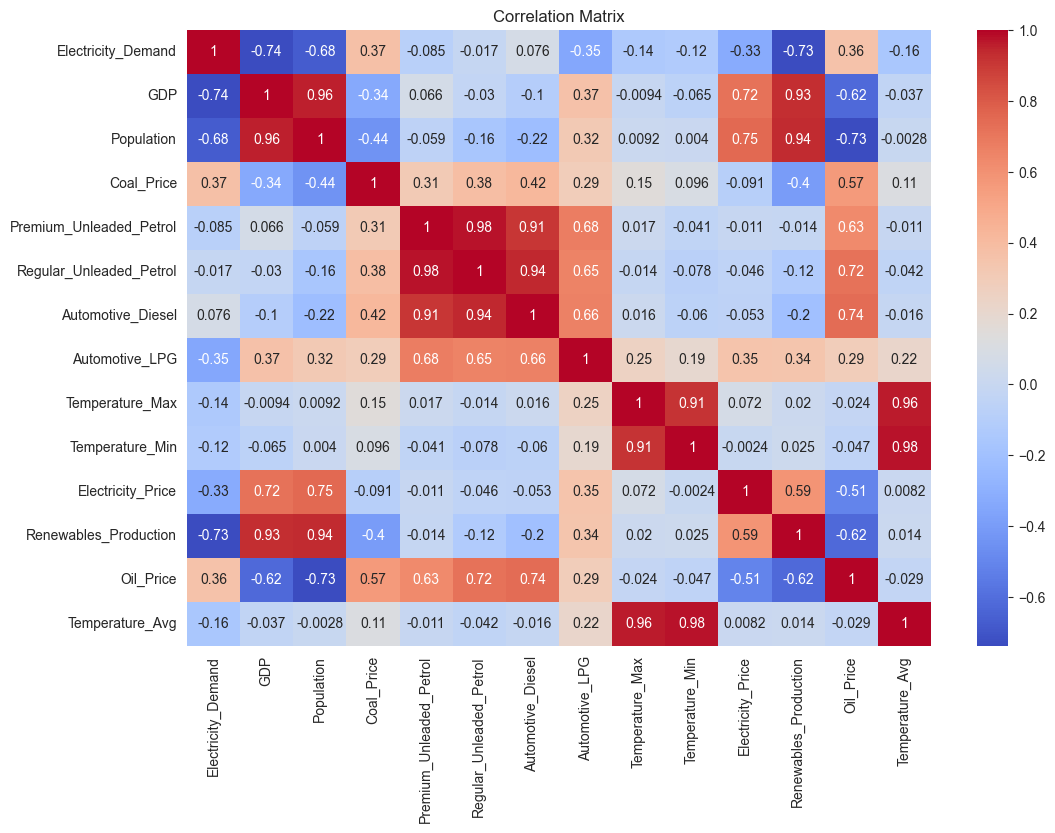

Electricity_Demand         1.000000
Coal_Price                 0.371817
Oil_Price                  0.357952
Automotive_Diesel          0.076427
Regular_Unleaded_Petrol   -0.017037
Premium_Unleaded_Petrol   -0.085003
Temperature_Min           -0.123126
Temperature_Max           -0.138913
Temperature_Avg           -0.159489
Electricity_Price         -0.327437
Automotive_LPG            -0.346566
Population                -0.676495
Renewables_Production     -0.732432
GDP                       -0.738298
Name: Electricity_Demand, dtype: float64


In [29]:
# Setting 'Time_Period' as index
df.set_index('Time_Period', inplace=True)

# Exclude Year and Quarter columns from correlation analysis
df_analysis = df.drop(columns=['Year', 'Quarter'], errors='ignore')

# Calculate correlation matrix
corr_matrix = df_analysis.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Display correlation values with Electricity_Demand specifically
electricity_demand_correlation = corr_matrix['Electricity_Demand'].sort_values(ascending=False)
print(electricity_demand_correlation)

## Train/Test Split
- 2010-2018 as training
- 2019-2020 as testing
- Average temperature used for temperature

In [70]:
# Splitting the data according to the specified years and quarters
train = df[(df['Year'] < 2018)]
test = df[((df['Year'] >= 2018) & (df['Year'] < 2020))]

def test_split(features: list = None):
    _train = df[(df['Year'] < 2018)]
    _test = df[((df['Year'] >= 2018) & (df['Year'] < 2020))]

    if features:
        _X_train = _train[features]
        _y_train = _train['Electricity_Demand']
        _X_test = _test[features]
        _y_test = _test['Electricity_Demand']
    else:
        _X_train = _train.drop(['Electricity_Demand', 'Year', 'Quarter', 'Temperature_Min', 'Temperature_Max'], axis=1)
        _y_train = _train['Electricity_Demand']
        _X_test = _test.drop(['Electricity_Demand', 'Year', 'Quarter','Temperature_Min', 'Temperature_Max'], axis=1)
        _y_test = _test['Electricity_Demand']
    return _X_train, _y_train, _X_test, _y_test

def train_model2(in_model):
    # Fit the model on the training data
    in_model.fit(X_train, y_train)

    # Get training set scores
    y_pred_train = in_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    
    # Predict on the test set
    y_pred = in_model.predict(X_test)
    
    # Calculate the RMSE for the test set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate the R-squared value for the test set
    test_r2 = r2_score(y_test, y_pred)
    
    # print(f"{in_model.__class__.__name__} Train RMSE, R-squared: {train_rmse:6.4f}, {train_r2:6.4f}")
    # print(f"{in_model.__class__.__name__} Test  RMSE, R-squared: {test_rmse:6.4f}, {test_r2:6.4f}")
    return in_model, test_rmse, test_r2, train_rmse, train_r2
    
def find_better_model(model_class, params):
    min_rmse, best_model, best_param_set, best_r2 = None, None, None, None
    results = []
    for param_set in itertools.product(*params.values()):
        kw_args = dict(zip(params.keys(), param_set))
        # print(f'{model_class.__name__} | ' + ', '.join([f'{k}: {v}' for k, v in kw_args.items()]))
        model = model_class(**kw_args)
        out_model, rmse, r2, train_rmse, train_r2 = train_model2(model)
        results.append({**kw_args, 'test_rmse': rmse, 'test_r2': r2, 'train_rmse': train_rmse, 'train_r2': train_r2})
        if min_rmse is None or rmse < min_rmse:
            min_rmse = rmse
            best_r2 = r2
            best_model = out_model
            best_param_set = kw_args
    print(f'Best model with params {model_class.__name__}({best_param_set})\nRMSE: {min_rmse:0.4f}\nR-squared: {best_r2:0.4f}')
    return best_model, pd.DataFrame(results), min_rmse

def scatterplot(data, x, y, x2, y2, hue, style, title, title2, file_name='scatterplot.png'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, style=style, ax=ax1)
    ax1.title.set_text(title)
    sns.scatterplot(data=data, x=x2, y=y2, hue=hue, style=style, ax=ax2)
    ax2.title.set_text(title2)
    sns.scatterplot(data=data, x=x, y=x2, hue=hue, style=style, ax=ax3)
    ax3.title.set_text('Training')
    sns.scatterplot(data=data, x=y, y=y2, hue=hue, style=style, ax=ax4)
    ax4.title.set_text('Test')
    sns.set_style("whitegrid")
    plt.tight_layout()
    plt.savefig(file_name, dpi=200)
    plt.show()
    # RMSE vs. Number of Features
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', linestyle='-')
    # plt.title(f'RMSE vs. Number of Features ({model_name})')
    # plt.xlabel('Number of Features')
    # plt.ylabel('RMSE')
    # plt.grid(True)
    # plt.show()

def plot_test(in_model):
    plt.figure(figsize=(8, 4.5))
    plt.title(f'{in_model.__class__.__name__} Model')
    plt.scatter(test.reset_index()['Time_Period'], y_test)
    sns.set_style("whitegrid")
    plt.tight_layout()
    plt.plot(test.reset_index()['Time_Period'], in_model.predict(X_test), color='black')
    plt.show()

def plot_full(in_model, file_name='plot_full.png'):
    plt.figure(figsize=(9, 4.5))
    plt.title(f'{in_model.__class__.__name__} Model')
    plt.scatter(train.reset_index()['Time_Period'], y_train)
    plt.scatter(test.reset_index()['Time_Period'], y_test)
    plt.plot(train.reset_index()['Time_Period'], in_model.predict(X_train), color='black')
    plt.plot(test.reset_index()['Time_Period'], in_model.predict(X_test), color='green')
    plt.ylim(ymin=0)
    sns.set_style("whitegrid")
    # plt.tight_layout()
    plt.title(f'{in_model.__class__.__name__} Model Prediction Performance - Training vs Test')
    plt.xlabel('Year')
    plt.ylabel('Electicity Demand (Normalised)')
    plt.savefig(file_name, dpi=200, bbox_inches='tight')
    plt.show()

def find_best_features(model_class, hyper_parameters, features = None, min_features: int = 1, max_features: int = 5):
    global X_train, y_train, X_test, y_test
    if not features:
        features = ['GDP', 'Population', 'Coal_Price', 'Regular_Unleaded_Petrol', 'Automotive_LPG', 'Temperature_Avg', 'Electricity_Price', 'Renewables_Production', 'Oil_Price']
    combinations = []
    for i in range(min_features, max_features + 1):
        combinations.extend(itertools.combinations(features, i))
    print(len(combinations), 'combinations')

    results = []
    min_rmse = None
    for i, columns in enumerate(combinations, start=1):
        X_train, y_train, X_test, y_test = test_split(list(columns))
        model, df_results, best_rmse = find_better_model(model_class, hyper_parameters)
        mean_rmse = df_results['test_rmse'].mean()
        max_r2 = df_results['test_r2'].max()
        results.append([columns, best_rmse, mean_rmse, max_r2])
        print(f'{i:3d}  {best_rmse:6.4f} {columns}')
    result = pd.DataFrame(results, columns = ['features', 'min_rmse', 'mean_rmse', 'max_r2'])
    return result

Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 5})
RMSE: 0.0370
R-squared: 0.7964


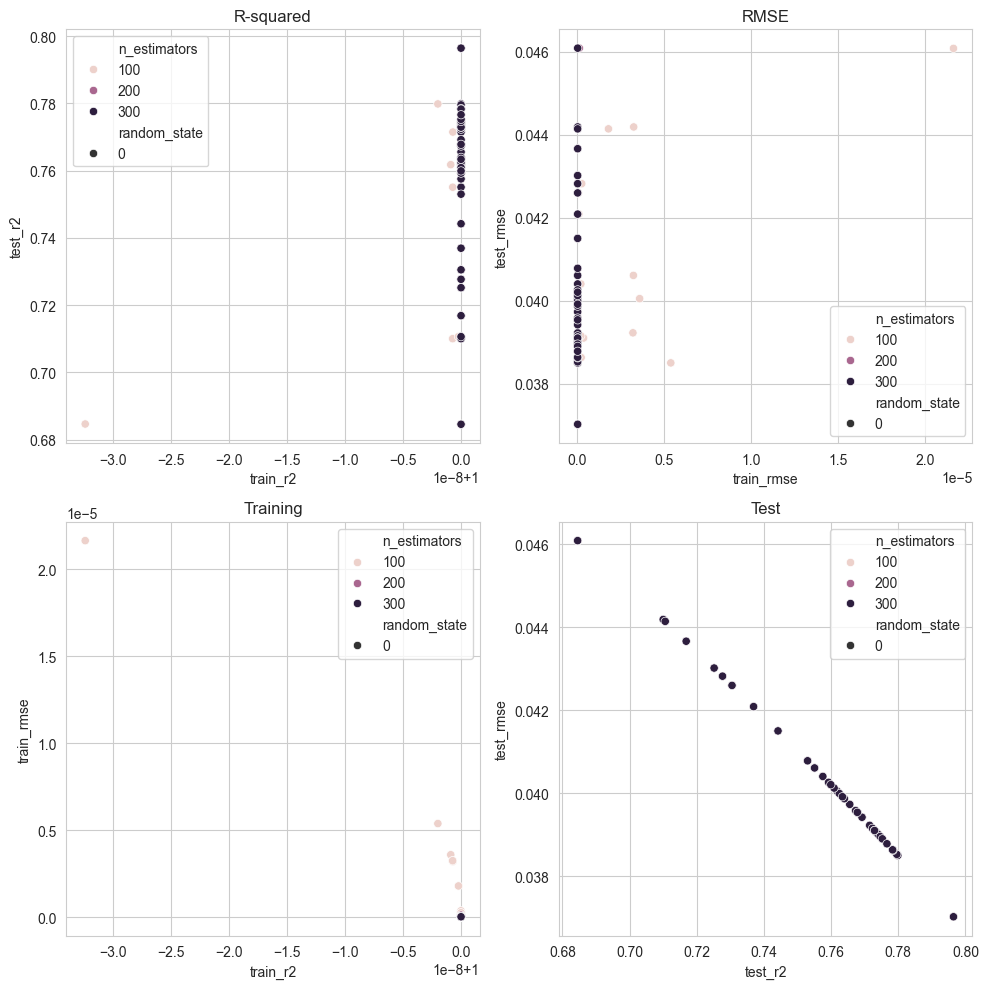

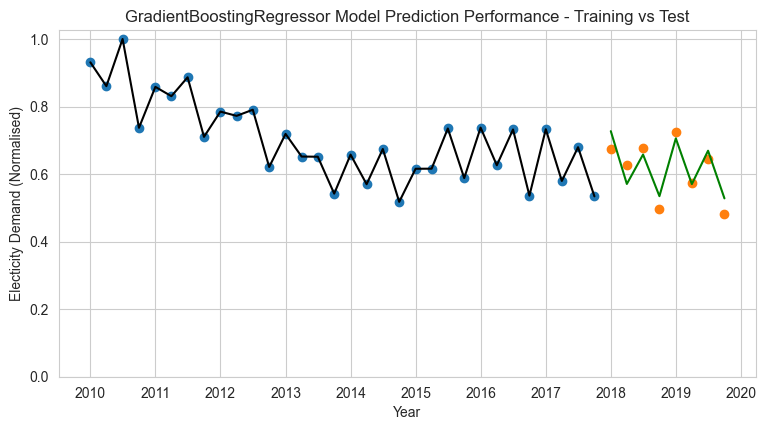

In [83]:
X_train, y_train, X_test, y_test = test_split()
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3],
                'max_depth': [4, 5, 6, 7, 10]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='random_state', title='R-squared', title2='RMSE')
plot_full(model)

In [84]:
best_features = find_best_features(GradientBoostingRegressor, {
                'random_state': [0],
                'n_estimators': [200],
                'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.3],
                'max_depth': [3, 4, 5]
                },
                min_features=1, max_features=6)
best_features['num_features'] = best_features['features'].apply(lambda x: len(x))
best_features.sort_values('min_rmse')

465 combinations
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1073
R-squared: -0.7097
  1  0.1073 ('GDP',)
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1129
R-squared: -0.8919
  2  0.1129 ('Population',)
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1650
R-squared: -3.0445
  3  0.1650 ('Coal_Price',)
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1733
R-squared: -3.4617
  4  0.1733 ('Regular_Unleaded_Petrol',)
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1457
R-squared: -2.1542
  5  0.1457 ('Automotive_LPG',)
Best model with params Gradi

,features,min_rmse,mean_rmse,max_r2,num_features
115,"(Regular_Unleaded_Petrol, Temperature_Avg, Oil...",0.020882,0.031512,0.935224,3
242,"(Regular_Unleaded_Petrol, Automotive_LPG, Temp...",0.022019,0.033206,0.927982,4
121,"(Automotive_LPG, Temperature_Avg, Oil_Price)",0.025685,0.032308,0.902005,3
41,"(Temperature_Avg, Oil_Price)",0.026929,0.033629,0.892283,2
246,"(Regular_Unleaded_Petrol, Temperature_Avg, Ele...",0.031295,0.035439,0.854518,4
...,...,...,...,...,...
32,"(Regular_Unleaded_Petrol, Electricity_Price)",0.136374,0.145272,-1.762582,2
4,"(Automotive_LPG,)",0.145720,0.145838,-2.154211,1
6,"(Electricity_Price,)",0.152434,0.153757,-2.451582,1
2,"(Coal_Price,)",0.165008,0.166223,-3.044462,1


In [89]:
print(list(best_features.iloc[115]['features']))
print(', '.join(best_features.iloc[115]['features']))
print(', '.join(best_features.iloc[242]['features']))
print(', '.join(best_features.iloc[246]['features']))
print(best_features[['num_features', 'min_rmse', 'max_r2', 'mean_rmse']].groupby('num_features').agg({'min_rmse': 'min', 'max_r2': 'max', 'mean_rmse': 'count'}).reset_index().to_latex(index=False))

['Regular_Unleaded_Petrol', 'Temperature_Avg', 'Oil_Price']
Regular_Unleaded_Petrol, Temperature_Avg, Oil_Price
Regular_Unleaded_Petrol, Automotive_LPG, Temperature_Avg, Oil_Price
Regular_Unleaded_Petrol, Temperature_Avg, Electricity_Price, Renewables_Production
\begin{tabular}{rrrr}
\toprule
num_features & min_rmse & max_r2 & mean_rmse \\
\midrule
1 & 0.103759 & -0.599212 & 9 \\
2 & 0.026929 & 0.892283 & 36 \\
3 & 0.020882 & 0.935224 & 84 \\
4 & 0.022019 & 0.927982 & 126 \\
5 & 0.031303 & 0.854444 & 126 \\
6 & 0.031366 & 0.853857 & 84 \\
\bottomrule
\end{tabular}



In [8]:
# X_train, y_train, X_test, y_test = test_split(['Population',
#  'Coal_Price',
#  'Automotive_LPG',
#  'Temperature_Avg',
#  'Electricity_Price'])
# model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
#                 'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
#                 'n_estimators': [150, 200, 250],
#                 'learning_rate': [0.195, 0.2, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
#                 'max_depth': [3, 4, 5]
#                 })
# scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
# plot_full(model)

In [9]:
# X_train, y_train, X_test, y_test = test_split(['Population',
#  'Coal_Price',
#  'Automotive_LPG',
#  'Temperature_Avg',
#  'Electricity_Price'])
# model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
#                 'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
#                 'n_estimators': [150, 200, 250],
#                 'learning_rate': [0.175, 0.18, 0.185, 0.190, 0.195, 0.2, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
#                 'max_depth': [3, 4, 5]
#                 })
# scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
# plot_full(model)

In [10]:
# X_train, y_train, X_test, y_test = test_split(['Population',
#  'Coal_Price',
#  'Automotive_LPG',
#  'Temperature_Avg',
#  'Electricity_Price'])
# model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
#                 'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
#                 'n_estimators': [50, 100, 150, 200, 250],
#                 'learning_rate': [0.175, 0.18, 0.185, 0.1875, 0.190, 0.1925, 0.195, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
#                 'max_depth': [3, 4, 5]
#                 })
# scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='max_depth', title='R-squared', title2='RMSE', file_name='gradient_boosting_train_v_test_scatter.png')
# plot_full(model, file_name='gradient_boosting_test_performance.png')


In [11]:
# features = ['Population',
#  'Coal_Price',
#  'Automotive_LPG',
#  'Temperature_Avg',
#  'Electricity_Price']
# X_train, y_train, X_test, y_test = test_split(features)
# print(f'Features: {features}')
# model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
#                 'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
#                 'n_estimators': [150, 200, 250],
#                 'learning_rate': [0.175, 0.18, 0.185, 0.187, 0.1875, 0.188, 0.188, 0.190, 0.1925, 0.195, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
#                 'max_depth': [3, 4, 5]
#                 })
# scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='max_depth', title='R-squared', title2='RMSE', file_name='gradient_boosting_train_v_test_scatter.png')
# plot_full(model)

# Champion Model
Tweaked the learning rate further but found no improvement over 0.188.

This is the champion model.

Features: ['Regular_Unleaded_Petrol', 'Temperature_Avg', 'Oil_Price']
Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 50, 'learning_rate': 0.195, 'max_depth': 3})
RMSE: 0.0180
R-squared: 0.9520


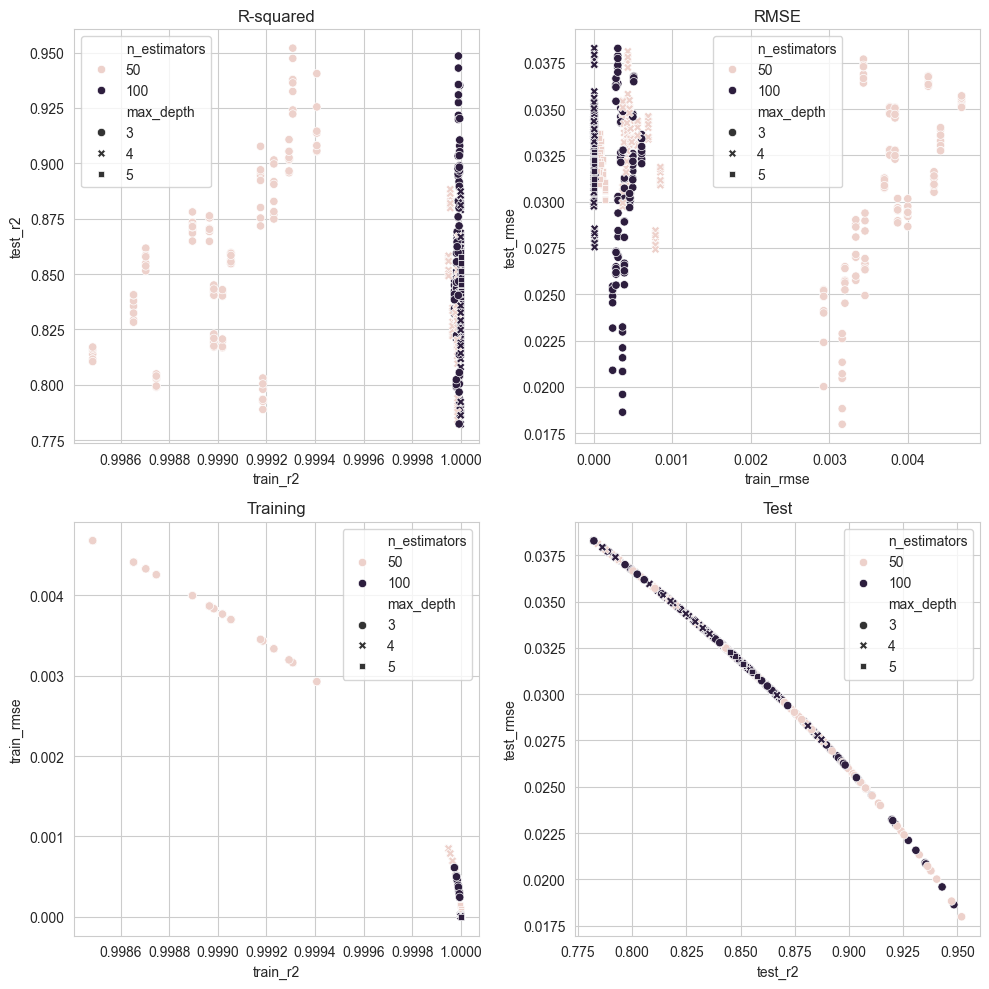

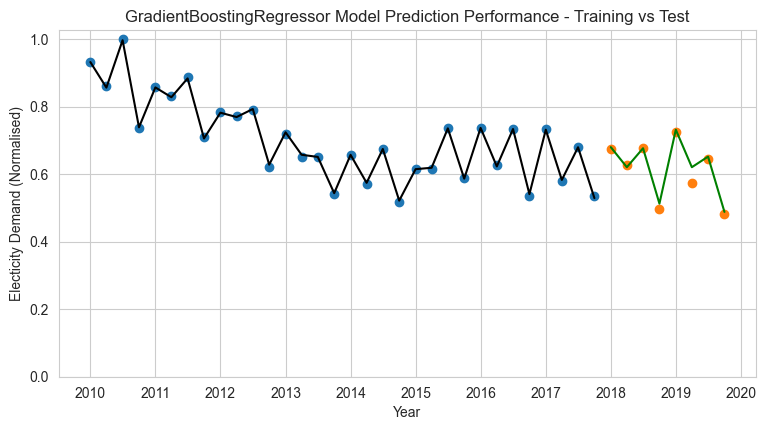

In [93]:
features = ['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price']
features = ['Regular_Unleaded_Petrol', 'Temperature_Avg', 'Oil_Price']
X_train, y_train, X_test, y_test = test_split(features)
print(f'Features: {features}')
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [50, 100], #, 150, 200, 250],
                'learning_rate': [0.175, 0.18, 0.185, 0.187, 0.1873, 0.1875, 0.1877, 0.1879, 0.188, 0.1885, 0.190, 0.1925, 0.194, 0.195, 0.196, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='max_depth', title='R-squared', title2='RMSE', file_name='gradient_boosting_train_v_test_scatter.png')
plot_full(model, file_name='gradient_boosting_test_performance.png')


# XGBoost

Best model with params XGBRegressor({'random_state': 0, 'learning_rate': 0.35, 'max_depth': 5})
RMSE: 0.0364
R-squared: 0.8036


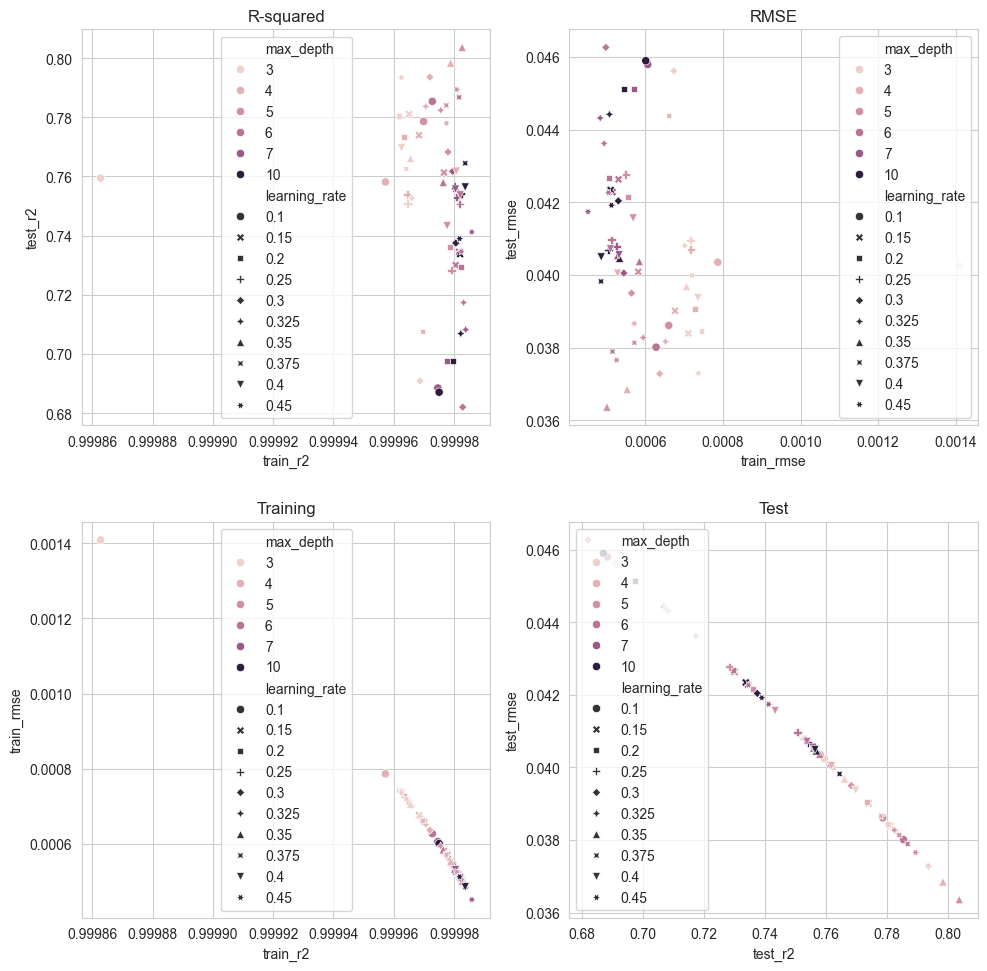

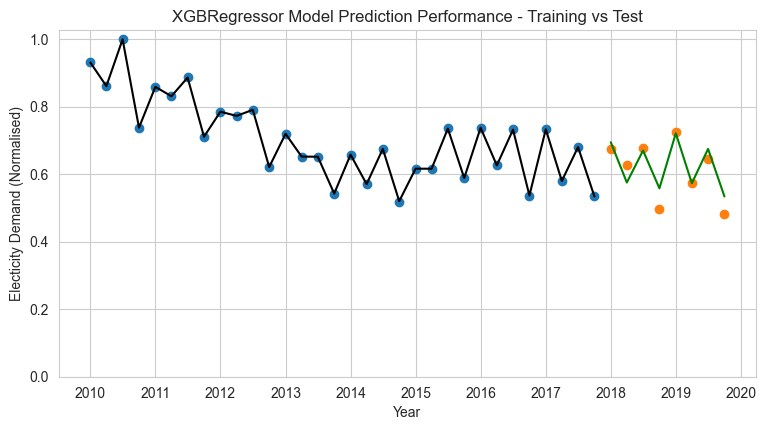

In [75]:
X_train, y_train, X_test, y_test = test_split()
model, df_results, best_rmse = find_better_model(XGBRegressor, {
                'random_state': [0],
                # 'n_estimators': [100, 200],
                'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.325, 0.35, 0.375, 0.4],
                'max_depth': [3, 4, 5, 6, 7, 10]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='max_depth', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

In [77]:
best_features = find_best_features(XGBRegressor, {
                'random_state': [0],
                'objective': ['reg:squarederror'],
                # 'n_estimators': [100, 200],
                'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                'max_depth': [3, 4, 5, 6]
                },
                min_features=1, max_features=6)
best_features['num_features'] = best_features['features'].apply(lambda x: len(x))
best_features.sort_values('min_rmse')

465 combinations
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.0988
R-squared: -0.4491
  1  0.0988 ('GDP',)
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1053
R-squared: -0.6471
  2  0.1053 ('Population',)
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1583
R-squared: -2.7239
  3  0.1583 ('Coal_Price',)
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1571
R-squared: -2.6640
  4  0.1571 ('Regular_Unleaded_Petrol',)
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.1, 'max_depth': 3})
RMSE: 0.1369
R-squared: -1.7857
  5  0.1369 ('Automotive_LPG',)
Best model with params XGBRegress

,features,min_rmse,mean_rmse,max_r2,num_features
115,"(Regular_Unleaded_Petrol, Temperature_Avg, Oil...",0.030050,0.048022,0.865869,3
367,"(Coal_Price, Regular_Unleaded_Petrol, Temperat...",0.030232,0.040980,0.864236,5
121,"(Automotive_LPG, Temperature_Avg, Oil_Price)",0.030842,0.039737,0.858700,3
251,"(Automotive_LPG, Temperature_Avg, Electricity_...",0.030856,0.034400,0.858577,4
119,"(Automotive_LPG, Temperature_Avg, Electricity_...",0.030915,0.036286,0.858028,3
...,...,...,...,...,...
362,"(Coal_Price, Regular_Unleaded_Petrol, Automoti...",0.153320,0.174204,-2.491795,5
3,"(Regular_Unleaded_Petrol,)",0.157055,0.171194,-2.664023,1
2,"(Coal_Price,)",0.158333,0.183092,-2.723884,1
226,"(Coal_Price, Regular_Unleaded_Petrol, Temperat...",0.164289,0.175776,-3.009288,4


In [78]:
print(', '.join(best_features.iloc[115]['features']))
print(best_features[['num_features', 'min_rmse', 'max_r2', 'mean_rmse']].groupby('num_features').agg({'min_rmse': 'min', 'max_r2': 'max', 'mean_rmse': 'count'}).reset_index().to_latex(index=False))
best_features

Regular_Unleaded_Petrol, Temperature_Avg, Oil_Price
\begin{tabular}{rrrr}
\toprule
num_features & min_rmse & max_r2 & mean_rmse \\
\midrule
1 & 0.068034 & 0.312453 & 9 \\
2 & 0.033561 & 0.832688 & 36 \\
3 & 0.030050 & 0.865869 & 84 \\
4 & 0.030856 & 0.858577 & 126 \\
5 & 0.030232 & 0.864236 & 126 \\
6 & 0.032318 & 0.844858 & 84 \\
\bottomrule
\end{tabular}



,features,min_rmse,mean_rmse,max_r2,num_features
0,"(GDP,)",0.098768,0.102781,-0.449055,1
1,"(Population,)",0.105302,0.111700,-0.647107,1
2,"(Coal_Price,)",0.158333,0.183092,-2.723884,1
3,"(Regular_Unleaded_Petrol,)",0.157055,0.171194,-2.664023,1
4,"(Automotive_LPG,)",0.136942,0.144183,-1.785660,1
...,...,...,...,...,...
460,"(Coal_Price, Regular_Unleaded_Petrol, Automoti...",0.035350,0.040978,0.814375,6
461,"(Coal_Price, Regular_Unleaded_Petrol, Automoti...",0.094265,0.100350,-0.319935,6
462,"(Coal_Price, Regular_Unleaded_Petrol, Temperat...",0.035596,0.041290,0.811784,6
463,"(Coal_Price, Automotive_LPG, Temperature_Avg, ...",0.036625,0.041301,0.800745,6


Features: ['Regular_Unleaded_Petrol', 'Temperature_Avg', 'Oil_Price']
Best model with params XGBRegressor({'random_state': 0, 'objective': 'reg:squarederror', 'learning_rate': 0.35, 'max_depth': 3})
RMSE: 0.0300
R-squared: 0.8659


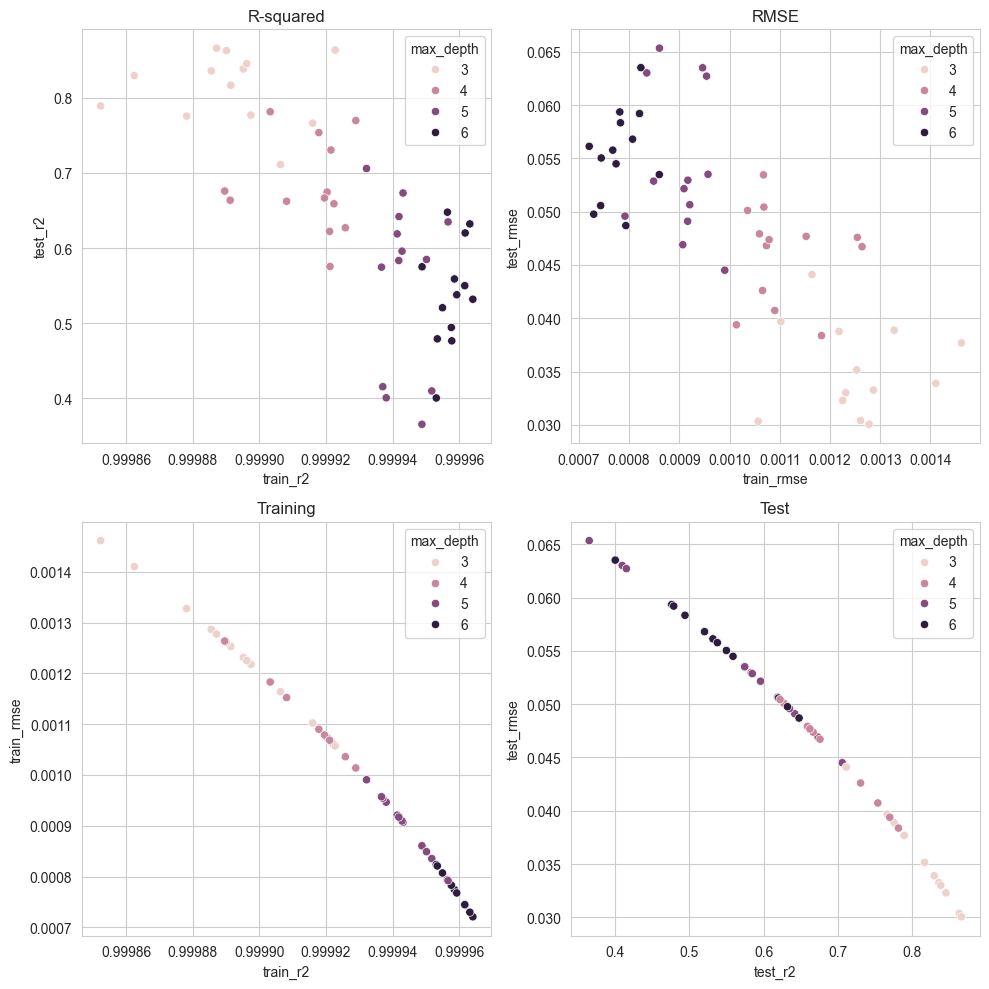

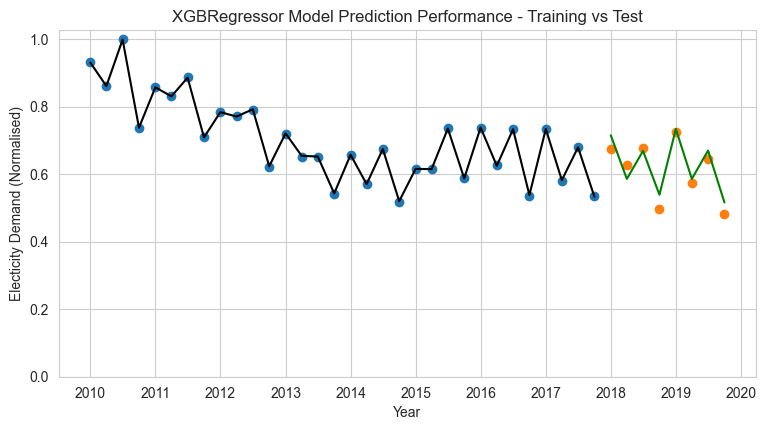

In [98]:
features = ['Regular_Unleaded_Petrol',
 'Temperature_Avg',
 'Oil_Price']
X_train, y_train, X_test, y_test = test_split(features)
print(f'Features: {features}')
model, df_results, best_rmse = find_better_model(XGBRegressor, {
                'random_state': [0],
                'objective': ['reg:squarederror'],
                # 'n_estimators': [50, 100, 150, 200, 250],
                'learning_rate': [0.1875, 0.2, 0.2125, 0.225, 0.25, 0.275, 0.3, 0.325, 0.349, 0.35, 0.351, 0.375, 0.4], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5, 6]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='max_depth', style=None, title='R-squared', title2='RMSE', file_name='xgboost_train_v_test_scatter.png')
plot_full(model, file_name='xgboost_test_performance.png')
